In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

In [ ]:
# Dataset paths
data_dir = "/kaggle/input/deepfake-and-real-images/Dataset"
train_dir = os.path.join(data_dir, "Train")
val_dir = os.path.join(data_dir, "Validation")
test_dir = os.path.join(data_dir, "Test")

# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 256, 256
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


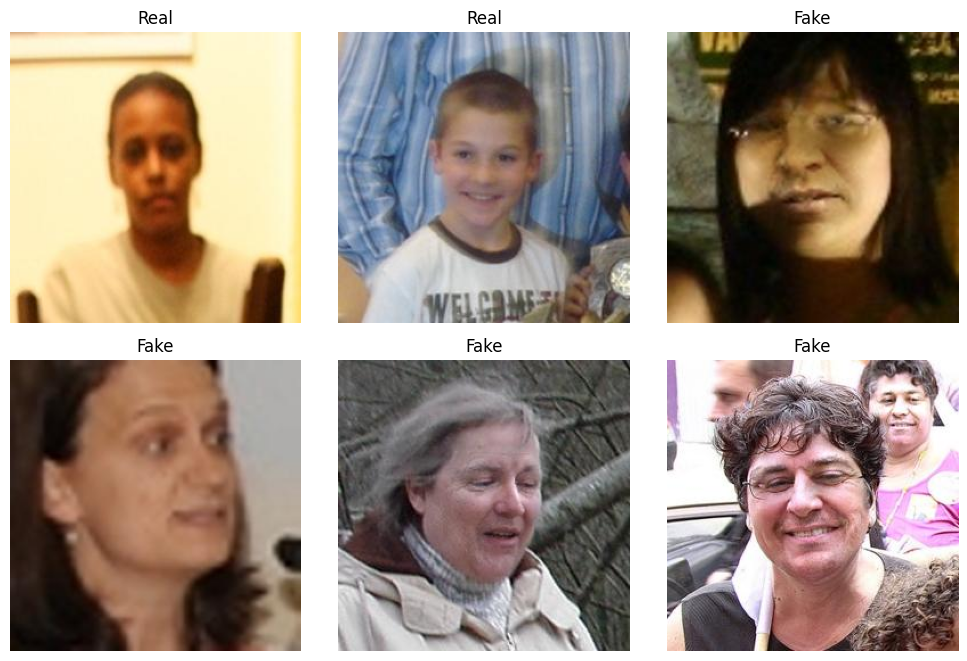

In [18]:
# Plot sample images and their class labels
class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [63]:
# MesoNet Model
from tensorflow.keras import layers, models

def MesoNet():
    model = models.Sequential()
    model.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(8, (5, 5), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(16, (5, 5), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(16, (5, 5), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(4, 4)))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

model = MesoNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [68]:
def ResNetModel():
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    for filters in [64, 128, 256]:
        residual = layers.Conv2D(filters, (1, 1), padding='same')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, residual])
        x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model


In [69]:
def DenseNetModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [72]:
models_dict = {
    "ResNet": ResNetModel(),
    "DenseNet": DenseNetModel(),
    "MesoNet": MesoNet()
}

EPOCHS = 5
model_histories = {}
for name, model in models_dict.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS
    )
    model_histories[name] = history



Training ResNet...
Epoch 1/5


2025-05-01 14:31:30.168848: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-01 14:31:30.374321: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.205667465s
Trying algorithm eng12{k11=0} for conv (f32[32,256,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,64,64]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward

 616/4376 ━━━━━━━━━━━━━━━━━━━━ 12:03 192ms/step - accuracy: 0.5511 - loss: 0.7066

E0000 00:00:1746110033.256476     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746110033.559141     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746110034.128832     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1746110034.358239     143 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1010s 222ms/step - accuracy: 0.6826 - loss: 0.5658 - val_accuracy: 0.7867 - val_loss: 0.5247
Epoch 2/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 938s 214ms/step - accuracy: 0.9217 - loss: 0.1977 - val_accuracy: 0.8676 - val_loss: 0.3308
Epoch 3/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 930s 212ms/step - accuracy: 0.9444 - loss: 0.1434 - val_accuracy: 0.8954 - val_loss: 0.2514
Epoch 4/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 925s 211ms/step - accuracy: 0.9533 - loss: 0.1203 - val_accuracy: 0.9028 - val_loss: 0.2548
Epoch 5/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 937s 214ms/step - accuracy: 0.9607 - loss: 0.1033 - val_accuracy: 0.9075 - val_loss: 0.2201

Training DenseNet...
Epoch 1/5


2025-05-01 15:50:31.046522: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,252,252]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-01 15:50:31.074320: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.027940403s
Trying algorithm eng0{} for conv (f32[32,32,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,252,252]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","con

4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1612s 362ms/step - accuracy: 0.5844 - loss: 0.6760 - val_accuracy: 0.5505 - val_loss: 0.6945
Epoch 2/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1568s 358ms/step - accuracy: 0.6610 - loss: 0.6241 - val_accuracy: 0.6688 - val_loss: 0.5968
Epoch 3/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1554s 355ms/step - accuracy: 0.7299 - loss: 0.5509 - val_accuracy: 0.6796 - val_loss: 0.6415
Epoch 4/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1552s 355ms/step - accuracy: 0.8069 - loss: 0.4391 - val_accuracy: 0.7948 - val_loss: 0.5006
Epoch 5/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1552s 355ms/step - accuracy: 0.8326 - loss: 0.3897 - val_accuracy: 0.7868 - val_loss: 0.4921

Training MesoNet...
Epoch 1/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 437s 98ms/step - accuracy: 0.6561 - loss: 0.6064 - val_accuracy: 0.8533 - val_loss: 0.3142
Epoch 2/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 415s 95ms/step - accuracy: 0.8764 - loss: 0.2770 - val_accuracy: 0.8961 - val_loss: 0.2389
Epoch 3/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 378s 86ms/step

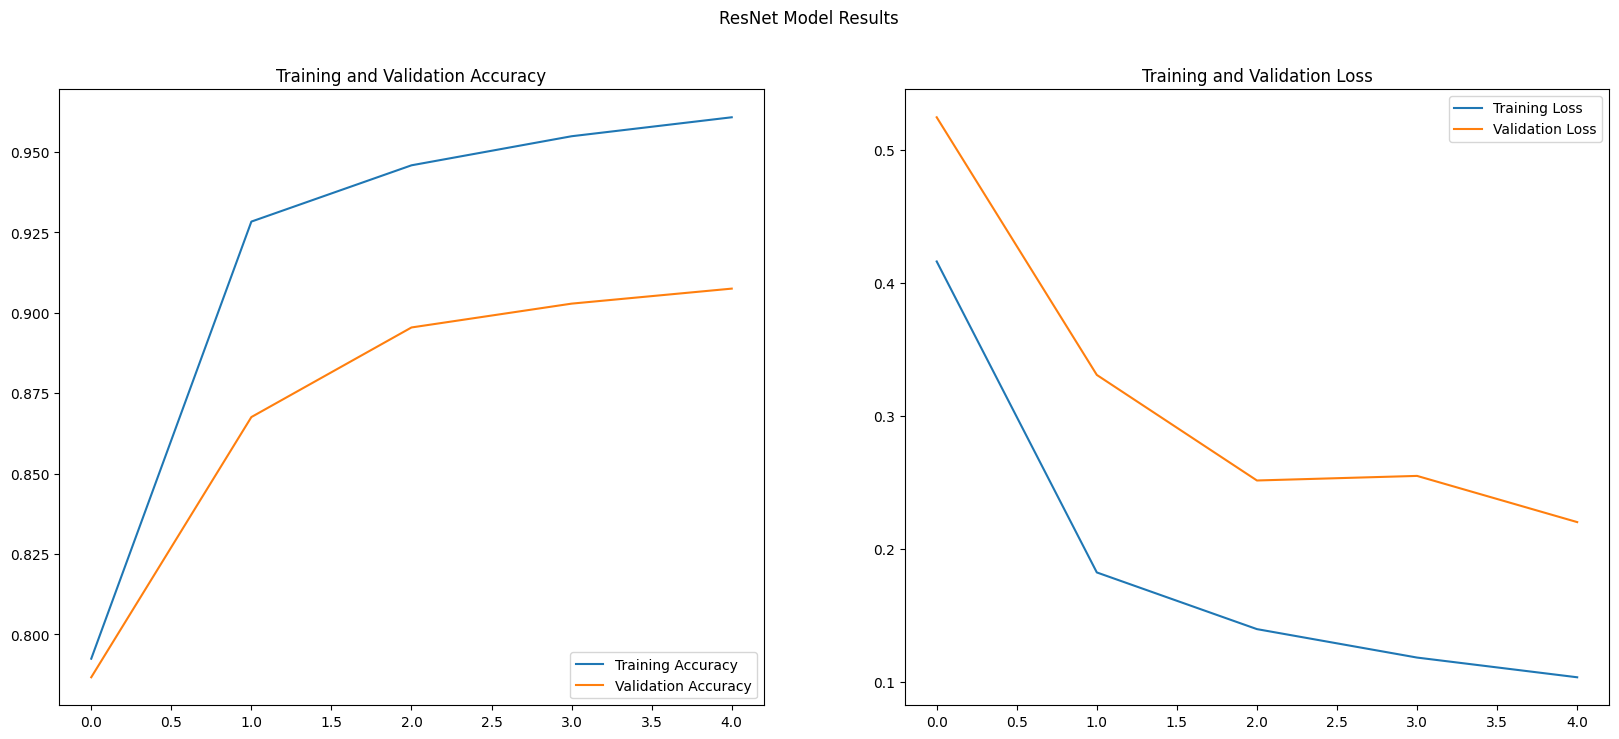

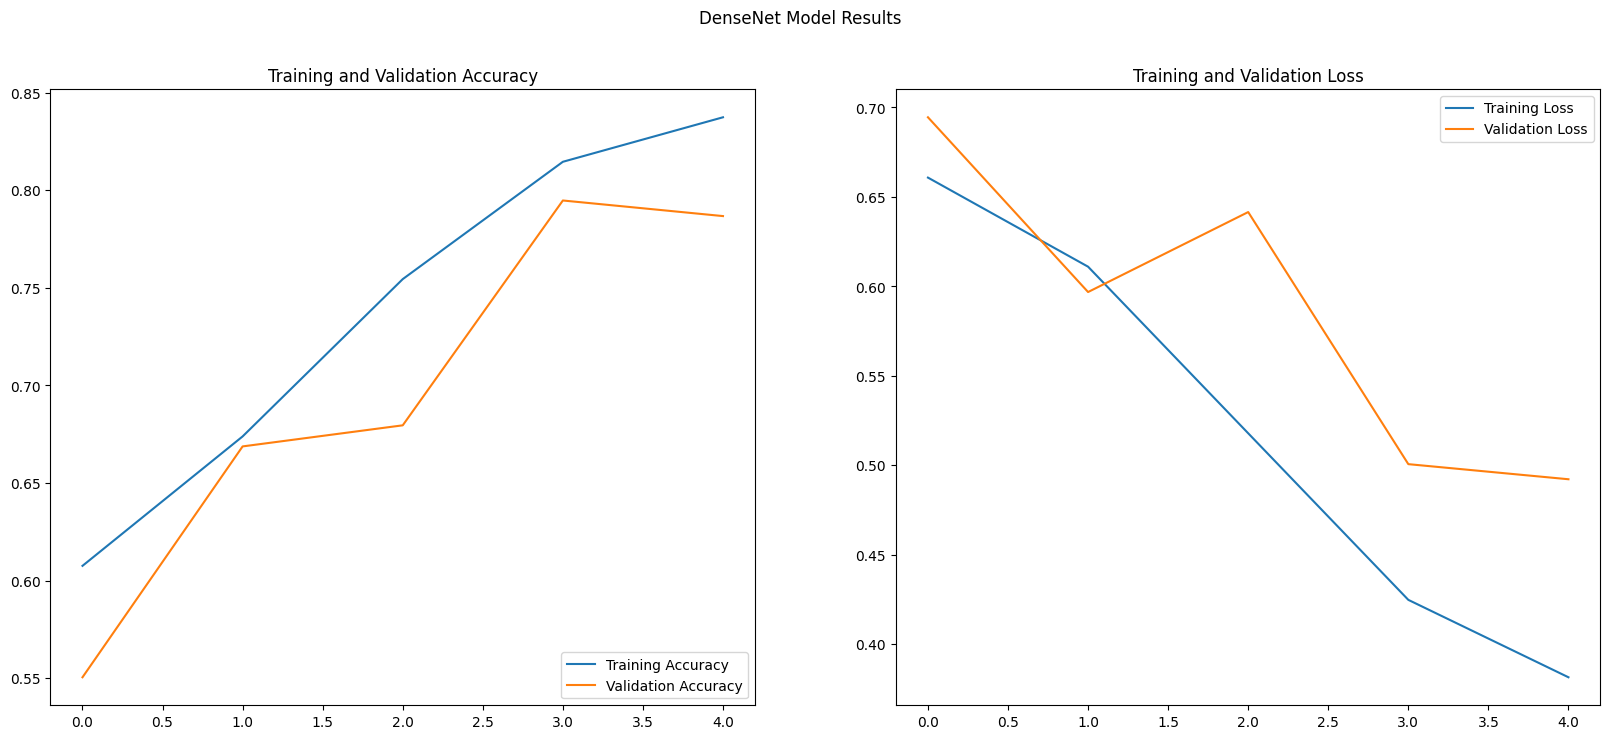

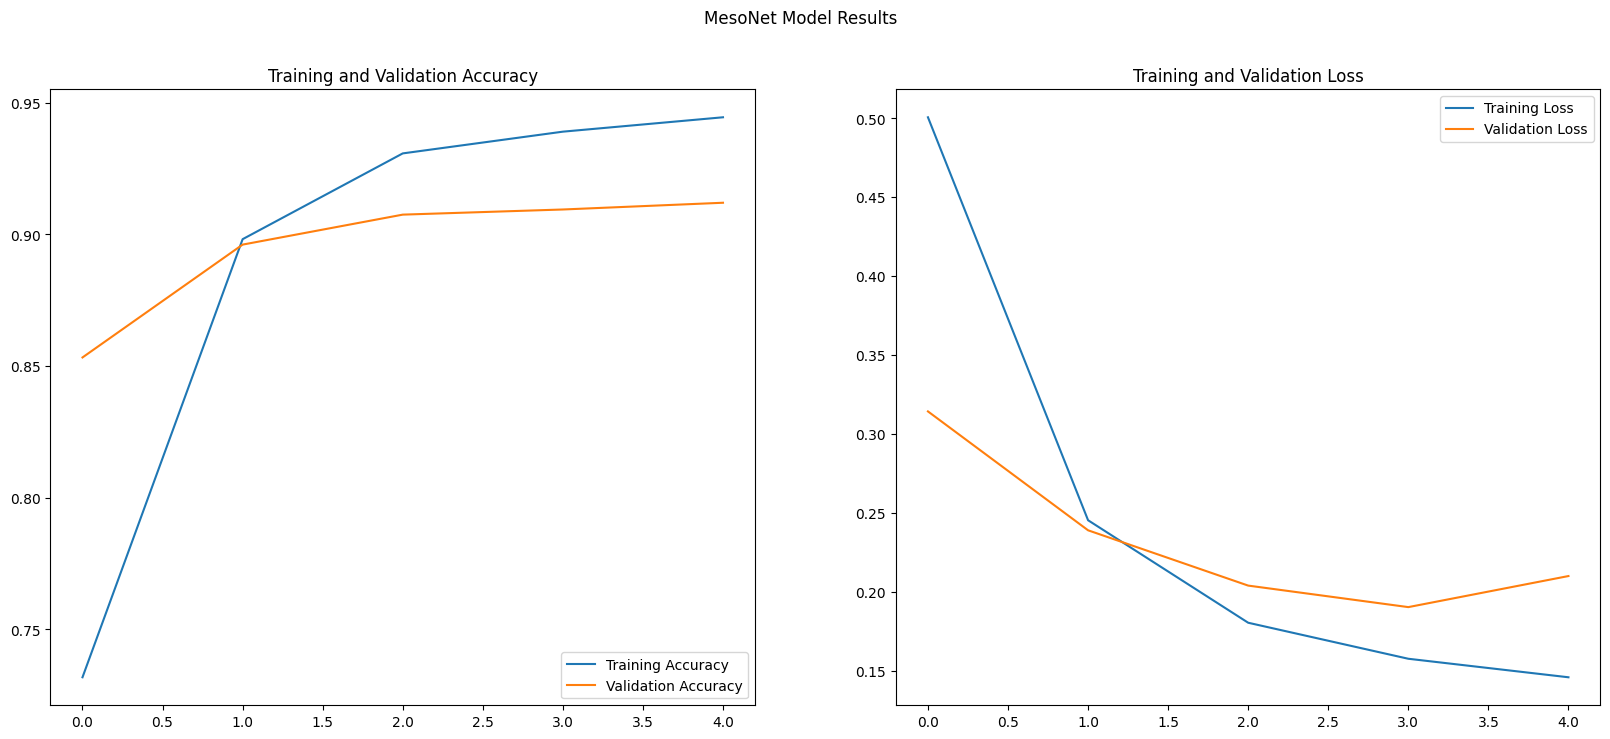

In [74]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

for name, history in model_histories.items():
    plot_model_performance(name, history)

In [77]:
model_results = {}

for name, model in models_dict.items():
    model_results[name] = model.evaluate(test_generator)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {model_results[name][1]*100:.2f}%")
    print(f"Test loss: {model_results[name][0]:.4f}", end = '\n\n')

341/341 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.8160 - loss: 0.4098
ResNet Model Results:
Test accuracy: 86.97%
Test loss: 0.3155

341/341 ━━━━━━━━━━━━━━━━━━━━ 42s 123ms/step - accuracy: 0.7450 - loss: 0.5128
DenseNet Model Results:
Test accuracy: 67.99%
Test loss: 0.7215

341/341 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9060 - loss: 0.2115
MesoNet Model Results:
Test accuracy: 83.92%
Test loss: 0.3569



341/341 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step

Classification Report for ResNet:
              precision    recall  f1-score   support

        Fake       0.96      0.77      0.86      5492
        Real       0.81      0.97      0.88      5413

    accuracy                           0.87     10905
   macro avg       0.88      0.87      0.87     10905
weighted avg       0.89      0.87      0.87     10905



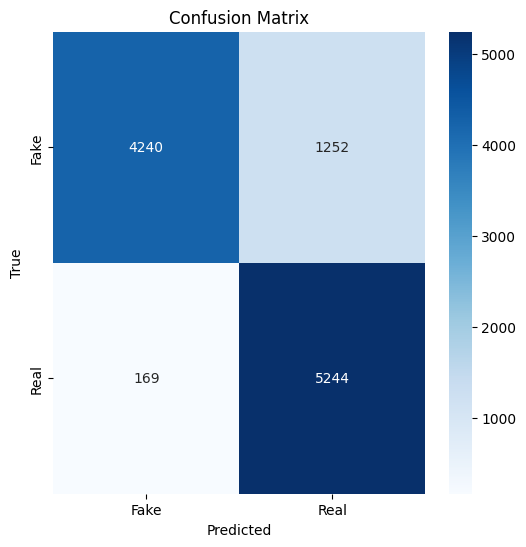

341/341 ━━━━━━━━━━━━━━━━━━━━ 36s 105ms/step

Classification Report for DenseNet:
              precision    recall  f1-score   support

        Fake       0.65      0.77      0.71      5492
        Real       0.72      0.59      0.65      5413

    accuracy                           0.68     10905
   macro avg       0.69      0.68      0.68     10905
weighted avg       0.69      0.68      0.68     10905



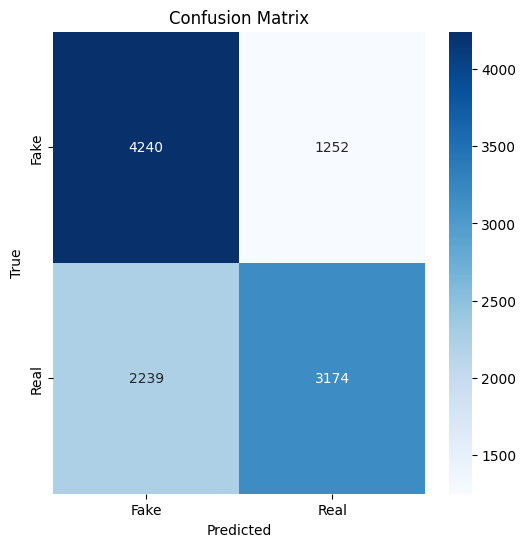

341/341 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step

Classification Report for MesoNet:
              precision    recall  f1-score   support

        Fake       0.79      0.93      0.85      5492
        Real       0.91      0.75      0.82      5413

    accuracy                           0.84     10905
   macro avg       0.85      0.84      0.84     10905
weighted avg       0.85      0.84      0.84     10905



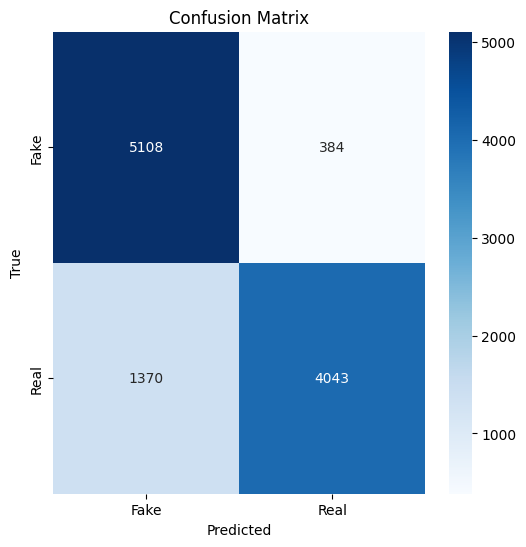

In [ ]:
for name, model in models_dict.items():
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)
    y_true = test_generator.classes
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred_classes, target_names=["Fake", "Real"]))
    cm = confusion_matrix(y_true, y_pred_classes)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
ResNet Prediction: Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
DenseNet Prediction: Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MesoNet Prediction: Fake


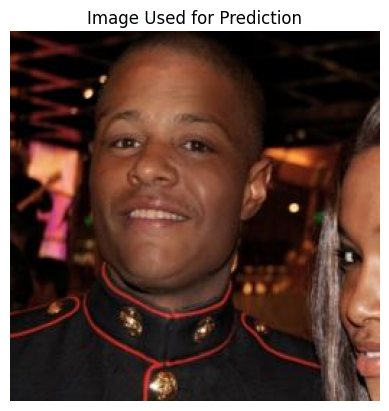

In [92]:
from tensorflow.keras.preprocessing import image

# Function to load and predict a single image
def predict_single_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    class_names = ['Fake', 'Real']

    plt.imshow(img)
    plt.axis("off")
    for name, model in models_dict.items():
        prediction = model.predict(img_array)
        class_idx = (prediction > 0.5).astype(int)
        print(f"{name} Prediction: {class_names[class_idx[0][0]]}")
    plt.title("Image Used for Prediction")
    plt.show()

# Example usage (provide the path to your image)
img_path = "/kaggle/input/deepfake-and-real-images/Dataset/Test/Fake/fake_145.jpg"  # Change this to the path of the image you want to predict

predict_single_image(img_path)